In [ ]:
# ПОДКЛЮЧЕНИЕ БИБЛИОТЕК
import os
import datetime
from tqdm.auto import tqdm
import hashlib
from base64 import b64encode
import collections

import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.sandbox.stats.multicomp
from statsmodels.stats.weightstats import ztest
from sklearn.utils import shuffle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ФУНКЦИИ

# Генерация соли
def salt_generator():
  salt = os.urandom(8)
  return b64encode(salt).decode('ascii')

# Делим на 2 равные группы
def groups_splitter(data: pd.DataFrame, user_salt: str = None):
  user_salt = user_salt if user_salt else salt_generator()

  user_ids = data['user_id'].astype(str).values + '#' + user_salt
  hashes = np.array([hashlib.sha256(uid.encode('utf-8')).hexdigest() for uid in user_ids])
  groups = np.array([int(h[-6:], 16) % 2 for h in hashes])
  data['group'] = np.where(groups == 0, 'A', 'B')

  return data.drop_duplicates()

### Загрузка данных

In [ ]:
shop_metrics_new = pd.read_csv('/content/drive/MyDrive/data_ab_homework2/shop_df_metrics_dec.csv', index_col=0)
shop_metrics_old = pd.read_csv('/content/drive/MyDrive/data_ab_homework2/shop_df_metrics_sept.csv', index_col=0)
shop_users_info = pd.read_csv('/content/drive/MyDrive/data_ab_homework2/shop_df_users.csv', index_col=0)

In [ ]:
shop_metrics_new.head(5)

,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt
0,1515915625353230683,A,1,1,339.79,0.0,0.0,0,0
1,1515915625353234047,A,1,9,861.86,0.0,0.0,0,0
2,1515915625353236157,A,1,4,179.60,0.0,0.0,0,0
3,1515915625353294441,B,1,28,4283.04,0.0,0.0,0,0
4,1515915625353386199,B,1,1,20.98,0.0,0.0,0,0


### 1. Применить ранговую трансформацию (потом t-test) и сравнить с результатами по Манну-Уитни на метрике cart_added_cnt

In [ ]:
def rank_transformation(df_a, df_b, metric):
    df = pd.concat([df_a, df_b], axis = 0)
    df['rank'] = df[metric].rank()
    return df

In [ ]:
ranked = rank_transformation(shop_metrics_new[shop_metrics_new.group == 'A'],
                             shop_metrics_new[shop_metrics_new.group == 'B'], metric='cart_added_cnt')

In [ ]:
ranked

,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt,rank
0,1515915625353230683,A,1,1,339.79,0.0,0.0,0,0,100038.5
1,1515915625353234047,A,1,9,861.86,0.0,0.0,0,0,100038.5
2,1515915625353236157,A,1,4,179.60,0.0,0.0,0,0,100038.5
5,1515915625353400724,A,1,2,103.33,0.0,0.0,0,0,100038.5
7,1515915625353416040,A,1,13,1861.21,0.0,0.0,0,0,100038.5
...,...,...,...,...,...,...,...,...,...,...
222516,1515915625611023671,B,1,1,32.22,0.0,0.0,0,0,100038.5
222517,1515915625611023730,B,1,1,219.94,0.0,0.0,0,0,100038.5
222518,1515915625611024014,B,1,1,80.03,0.0,0.0,0,0,100038.5
222519,1515915625611024020,B,1,1,64.92,0.0,0.0,0,0,100038.5


In [ ]:
print(ranked[ranked.group == 'A']['rank'].mean(),
      ranked[ranked.group == 'B']['rank'].mean(),
      ((ranked[ranked.group == 'B']['rank'].mean() - ranked[ranked.group == 'A']['rank'].mean()) /
       ranked[ranked.group == 'A']['rank'].mean()*100))

111170.45633348604 111351.6421897482 0.16298022175842064


In [ ]:
stats.ttest_ind(ranked[ranked.group == 'A']['rank'], ranked[ranked.group == 'B']['rank'])

TtestResult(statistic=-1.2743727811526857, pvalue=0.20253266477504916, df=222519.0)

In [ ]:
stats.mannwhitneyu(shop_metrics_new[shop_metrics_new.group == 'A']['cart_added_cnt'],
                shop_metrics_new[shop_metrics_new.group == 'B']['cart_added_cnt'])

MannwhitneyuResult(statistic=6179368188.5, pvalue=0.2025319893087626)

По результатам тестов ни t-тест с ранговой трансформацией, ни критерий Манна-Уитни не выявили статистически значимого эффекта.

Важно отметить, что для больших выборок результаты ранговой трансформации в t-тесте действительно могут быть близки к результатам рангового критерия Манна-Уитни.

In [ ]:
shop = shop_metrics_new.drop(columns=['group'])
shop

,user_id,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt
0,1515915625353230683,1,1,339.79,0.0,0.0,0,0
1,1515915625353234047,1,9,861.86,0.0,0.0,0,0
2,1515915625353236157,1,4,179.60,0.0,0.0,0,0
3,1515915625353294441,1,28,4283.04,0.0,0.0,0,0
4,1515915625353386199,1,1,20.98,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...
222516,1515915625611023671,1,1,32.22,0.0,0.0,0,0
222517,1515915625611023730,1,1,219.94,0.0,0.0,0,0
222518,1515915625611024014,1,1,80.03,0.0,0.0,0,0
222519,1515915625611024020,1,1,64.92,0.0,0.0,0,0


  0%|          | 0/1000 [00:00<?, ?it/s]

power: 70.6% , correctness: 93.8%


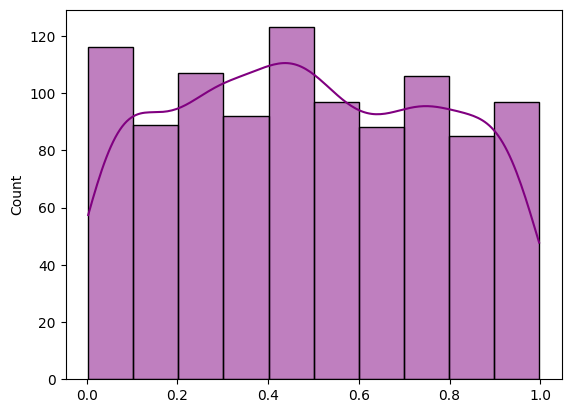

In [ ]:
# мощность и корректность t-test для исходной метрики

correctness = []
power = []

for i in tqdm(range(1000)):
    new_df = groups_splitter(shop.copy(), user_salt=salt_generator())

    vec_a = new_df[(new_df['group'] == 'A')]['cart_added_cnt']
    vec_b = new_df[(new_df['group'] == 'B')]['cart_added_cnt']

    p_cor, p_power = stats.ttest_ind(vec_a, vec_b).pvalue, stats.ttest_ind(vec_a, vec_b * 1.05).pvalue

    correctness.append(p_cor)
    power.append(p_power)

correctness = np.array(correctness)
sns.histplot(data=correctness, bins=10, color='purple', kde=True)

power = np.array(power)
print(f'power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%')

  0%|          | 0/1000 [00:00<?, ?it/s]

power: 99.9% , correctness: 95.89999999999999%


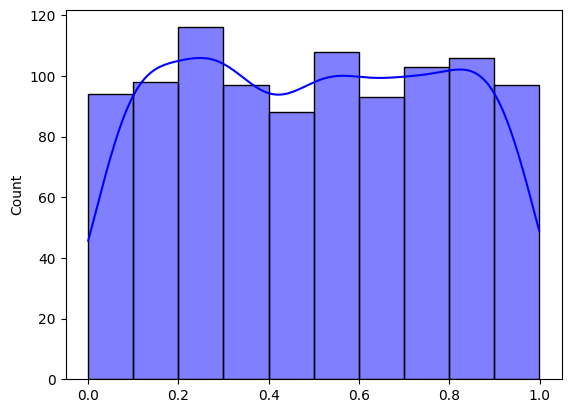

In [ ]:
# мощность и корректность для ранговой трансформации для t-теста

correctness = []
power = []

for i in tqdm(range(1000)):

    new_df = groups_splitter(shop.copy())

    ranked_df = rank_transformation(new_df[new_df.group == 'A'], new_df[new_df.group == 'B'], 'cart_added_cnt')

    vec_a = ranked_df[(ranked_df['group'] == 'A')]['rank']
    vec_b = ranked_df[(ranked_df['group'] == 'B')]['rank']

    vec_b_effect = new_df[new_df['group'] == 'B']['cart_added_cnt'] * 1.05

    new_df_b = new_df[new_df.group == 'B'].drop(columns=['cart_added_cnt'])
    new_df_b['cart_added_cnt'] = list(vec_b_effect)

    ranked_df_effect = rank_transformation(new_df[new_df.group == 'A'], new_df_b, 'cart_added_cnt')
    vec_a_power = ranked_df_effect[(ranked_df_effect['group'] == 'A')]['rank']
    vec_b_power = ranked_df_effect[(ranked_df_effect['group'] == 'B')]['rank']

    p_cor, p_power = stats.ttest_ind(vec_a, vec_b).pvalue, stats.ttest_ind(vec_a_power, vec_b_power).pvalue

    correctness.append(p_cor)
    power.append(p_power)

correctness = np.array(correctness)
sns.histplot(data=correctness, bins=10, color='blue', kde=True)

power = np.array(power)
print(f'power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%')

  0%|          | 0/1000 [00:00<?, ?it/s]

power: 100.0% , correctness: 95.39999999999999%


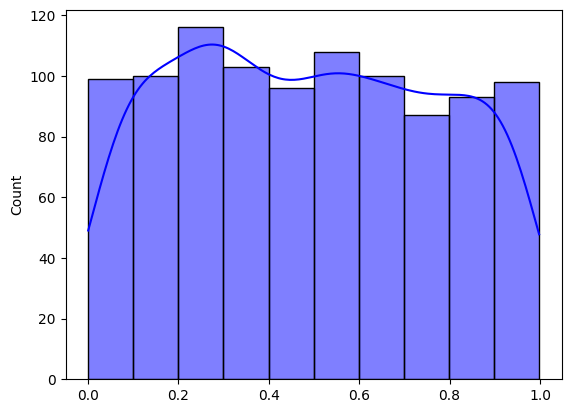

In [ ]:
# мощность и корректность для Манна-Уитни

correctness = []
power = []

for i in tqdm(range(1000)):
    new_df = groups_splitter(shop.copy())

    vec_a = new_df[(new_df['group'] == 'A')]['cart_added_cnt']
    vec_b = new_df[(new_df['group'] == 'B')]['cart_added_cnt']

    vec_b_effect = new_df[new_df['group'] == 'B']['cart_added_cnt'] * 1.05

    p_cor, p_power = stats.mannwhitneyu(vec_a, vec_b).pvalue, stats.mannwhitneyu(vec_a, vec_b_effect).pvalue

    correctness.append(p_cor)
    power.append(p_power)

correctness = np.array(correctness)
sns.histplot(data=correctness, bins=10, color='blue', kde=True)

power = np.array(power)
print(f'power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%')

Ранговая трансформация данных значительно повысила чувствительность t-теста, обеспечив выявление 5%-го эффекта с мощностью практически в 100% при уровне значимости 5%.

Тест Манна-Уитни, как ранговый метод, также успешно обнаружил различия в данных, демонстрируя мощность 100% при аналогичном уровне значимости.








### 2. Реализовать cuped-трансформацию и сравнить мощность t-критерия

В каждом случае фиксировать, на сколько сокращается дисперсия, проверять равны ли средние в группах в ковариате и совпадают ли средние в метрике до и после применения cuped

In [ ]:
def cuped_transform(df, metrics):

    new_columns = [str(m+'_cuped') for m in metrics]
    df[new_columns] = pd.DataFrame([[0.] * len(new_columns)], index=df.index)

    df_mini = df.fillna(0.)
    for m in metrics:
        covariate_column = str(m+'_covariate')
        cuped_column = str(m+'_cuped')
        mean_covariate = df_mini[covariate_column].mean()

        theta = (df_mini[m].cov(df_mini[covariate_column]))/(df_mini.loc[:,covariate_column].var())
        df_mini[cuped_column] = df_mini[m] - (df_mini[covariate_column] - mean_covariate) * theta

    df.update(df_mini)

    return df.drop_duplicates()

##### **обычная метрика cart_added_cnt**

In [ ]:
shop_metrics_old.head()

,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt
0,1515915625353226922,B,1,1,76.48,0.0,0.0,0,0
1,1515915625353230067,A,1,1,28.98,0.0,0.0,0,0
2,1515915625353230683,A,1,10,592.21,0.0,0.0,0,0
3,1515915625353230922,A,1,1,274.40,0.0,0.0,0,0
4,1515915625353234047,A,1,14,1857.94,0.0,0.0,0,0


In [ ]:
shop_metrics_all = pd.merge(shop_metrics_new, shop_metrics_old[['user_id', 'cart_added_cnt']], on=['user_id'], how='left')

In [ ]:
shop_metrics_all = shop_metrics_all\
                   .rename(columns={'cart_added_cnt_x': 'cart_added_cnt', 'cart_added_cnt_y': 'cart_added_cnt_covariate'})

In [ ]:
shop_metrics_all_cuped = cuped_transform(shop_metrics_all.copy(), ['cart_added_cnt'])
shop_metrics_all_cuped.head()

,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt,cart_added_cnt_covariate,cart_added_cnt_cuped
0,1515915625353230683,A,1,1,339.79,0.0,0.0,0,0,0,0.132761
1,1515915625353234047,A,1,9,861.86,0.0,0.0,0,0,0,0.132761
2,1515915625353236157,A,1,4,179.60,0.0,0.0,0,0,0,0.132761
3,1515915625353294441,B,1,28,4283.04,0.0,0.0,0,0,0,0.132761
4,1515915625353386199,B,1,1,20.98,0.0,0.0,0,0,0,0.132761


In [ ]:
stats.ttest_ind(shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'A']['cart_added_cnt_cuped'],
                shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'B']['cart_added_cnt_cuped'])

TtestResult(statistic=-1.3855896128552472, pvalue=0.16587364048446882, df=222519.0)

Сравним средние в измененной метрике и дисперсии:

In [ ]:
print(f'метрика_cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"]["cart_added_cnt_cuped"].mean()}, \
        метрика_cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"]["cart_added_cnt_cuped"].mean()}')
print(f'метрика без cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"]["cart_added_cnt"].mean()}, \
        метрика без cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"]["cart_added_cnt"].mean()}')

метрика_cuped A: 0.13638231572656986,         метрика_cuped B: 0.13721028984714492
метрика без cuped A: 0.1350419058398685,         метрика без cuped B: 0.1385521582733813


In [ ]:
print(f'метрика_cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"]["cart_added_cnt_cuped"].var()}, \
        метрика_cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"]["cart_added_cnt_cuped"].var()}')
print(f'метрика без cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"]["cart_added_cnt"].var()}, \
        метрика без cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"]["cart_added_cnt"].var()}')

метрика_cuped A: 0.018235183599737057,         метрика_cuped B: 0.021495363455189754
метрика без cuped A: 0.3805867322092098,         метрика без cuped B: 0.4247189893563619


Применение CUPED позволило существенно снизить дисперсию в данных: для группы A она уменьшилась с 0.3806 до 0.0182, а для группы B — с 0.4247 до 0.0215. При этом средние значения остались практически неизменными, что указывает на эффективность метода в улучшении точности сравнения групп.

  0%|          | 0/1000 [00:00<?, ?it/s]

power: 100.0% , correctness: 96.1%


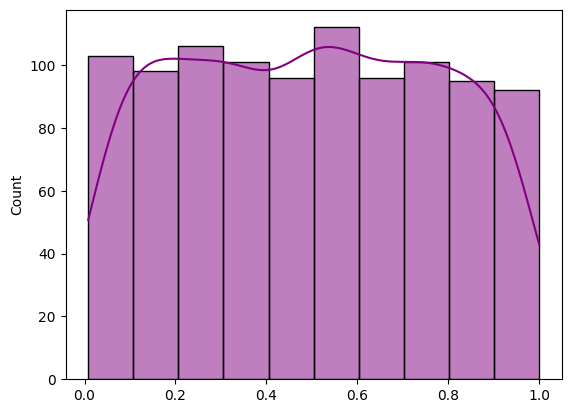

In [ ]:
correctness = []
power = []

for i in tqdm(range(1000)):

    new_df = groups_splitter(shop.copy(), user_salt=salt_generator())
    all_df = pd.merge(new_df, shop_metrics_old[['user_id', 'cart_added_cnt']], on=['user_id'], how='left')
    all_df = all_df.rename(columns={'cart_added_cnt_x': 'cart_added_cnt', 'cart_added_cnt_y': 'cart_added_cnt_covariate'})

    cuped_df = cuped_transform(all_df, ['cart_added_cnt'])

    vec_a = cuped_df[(cuped_df['group'] == 'A')]['cart_added_cnt_cuped']
    vec_b = cuped_df[(cuped_df['group'] == 'B')]['cart_added_cnt_cuped']

    vec_b_effect = cuped_df[(cuped_df['group'] == 'B')]['cart_added_cnt_cuped'] * 1.05

    p_cor, p_power = stats.ttest_ind(vec_a, vec_b).pvalue, stats.ttest_ind(vec_a, vec_b_effect).pvalue

    correctness.append(p_cor)
    power.append(p_power)

correctness = np.array(correctness)
sns.histplot(data=correctness, bins=10, color='purple', kde=True)

power = np.array(power)
print(f'power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%')

##### **логарфимированная метрика cart_added_cnt**

In [ ]:
shop_metrics_old['cart_added_cnt_ln'] = np.log(shop_metrics_old['cart_added_cnt'] + 1)
shop_metrics_new['cart_added_cnt_ln'] = np.log(shop_metrics_new['cart_added_cnt'] + 1)
shop_metrics_new['cart_added_cnt_effect_ln'] = np.log(shop_metrics_new['cart_added_cnt'] * 1.05 + 1)
shop = shop_metrics_new.drop(columns=['group'])

In [ ]:
shop_metrics_all = pd.merge(shop_metrics_new, shop_metrics_old[['user_id', 'cart_added_cnt_ln']], on=['user_id'], how='left')

In [ ]:
shop_metrics_all = shop_metrics_all\
                   .rename(columns={'cart_added_cnt_ln_x': 'cart_added_cnt_ln', 'cart_added_cnt_ln_y': 'cart_added_cnt_ln_covariate'})

In [ ]:
shop_metrics_all_cuped = cuped_transform(shop_metrics_all.copy(), ['cart_added_cnt_ln'])
shop_metrics_all_cuped.head()

,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt,cart_added_cnt_ln,cart_added_cnt_effect_ln,cart_added_cnt_ln_covariate,cart_added_cnt_ln_cuped
0,1515915625353230683,A,1,1,339.79,0.0,0.0,0,0,0.0,0.0,0.0,0.080004
1,1515915625353234047,A,1,9,861.86,0.0,0.0,0,0,0.0,0.0,0.0,0.080004
2,1515915625353236157,A,1,4,179.60,0.0,0.0,0,0,0.0,0.0,0.0,0.080004
3,1515915625353294441,B,1,28,4283.04,0.0,0.0,0,0,0.0,0.0,0.0,0.080004
4,1515915625353386199,B,1,1,20.98,0.0,0.0,0,0,0.0,0.0,0.0,0.080004


In [ ]:
stats.ttest_ind(shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'A']['cart_added_cnt_ln_cuped'],
                shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'B']['cart_added_cnt_ln_cuped'])

TtestResult(statistic=-2.049355101689238, pvalue=0.04042857406961156, df=222519.0)

После применения логарифмирования и CUPED-преобразования t-тест продемонстрировал статистически значимый эффект: p-value снизилось с 0.1659 до 0.0404, что указывает на улучшение чувствительности теста при уровне значимости 5%.

Сравним средние в измененной метрике и дисперсии:

In [ ]:
print(f'метрика_cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"]["cart_added_cnt_ln_cuped"].mean()}, \
        метрика_cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"]["cart_added_cnt_ln_cuped"].mean()}')
print(f'метрика без cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"]["cart_added_cnt_ln"].mean()}, \
        метрика без cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"]["cart_added_cnt_ln"].mean()}')

метрика_cuped A: 0.08034157852348506,         метрика_cuped B: 0.08072086382541406
метрика без cuped A: 0.07974289062640032,         метрика без cuped B: 0.08132020317245879


In [ ]:
print(f'метрика_cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"]["cart_added_cnt_ln_cuped"].var()}, \
        метрика_cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"]["cart_added_cnt_ln_cuped"].var()}')
print(f'метрика без cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"]["cart_added_cnt_ln"].var()}, \
        метрика без cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"]["cart_added_cnt_ln"].var()}')

метрика_cuped A: 0.0020550143786445562,         метрика_cuped B: 0.001755818733359531
метрика без cuped A: 0.0646623295575808,         метрика без cuped B: 0.06628259108485138


  0%|          | 0/1000 [00:00<?, ?it/s]

power: 100.0% , correctness: 94.10000000000001%


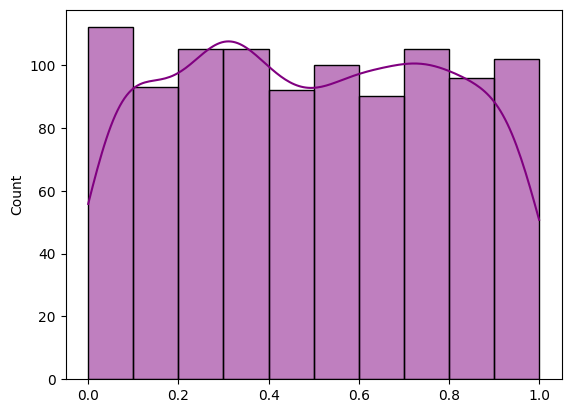

In [ ]:
correctness = []
power = []

for i in tqdm(range(1000)):

    new_df = groups_splitter(shop.copy(), user_salt=salt_generator())

    all_df = pd.merge(new_df, shop_metrics_old[['user_id', 'cart_added_cnt_ln']], on=['user_id'], how='left')
    all_df = all_df.rename(columns={'cart_added_cnt_ln_x': 'cart_added_cnt_ln', 'cart_added_cnt_ln_y': 'cart_added_cnt_ln_covariate'})
    all_df["cart_added_cnt_effect_ln_covariate"] = all_df["cart_added_cnt_ln_covariate"]

    cuped_df = cuped_transform(all_df, ['cart_added_cnt_ln', 'cart_added_cnt_effect_ln'])

    vec_a = cuped_df[(cuped_df['group'] == 'A')]['cart_added_cnt_ln_cuped']
    vec_b = cuped_df[(cuped_df['group'] == 'B')]['cart_added_cnt_ln_cuped']

    vec_b_effect = cuped_df[(cuped_df['group'] == 'B')]['cart_added_cnt_effect_ln_cuped']

    p_cor, p_power = stats.ttest_ind(vec_a, vec_b).pvalue, stats.ttest_ind(vec_a, vec_b_effect).pvalue

    correctness.append(p_cor)
    power.append(p_power)

correctness = np.array(correctness)
sns.histplot(data=correctness, bins=10, color='purple', kde=True)

power = np.array(power)
print(f'power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%')

Логарифмирование, в сочетании с CUPED, ожидаемо снизило разброс значений, что привело к стабильному результату с 100%-ой мощностью.

##### **метрика cart_added_cnt (а после подвергнуть ранговому преобразованию)**

In [ ]:
shop_metrics_all = pd.merge(shop_metrics_new, shop_metrics_old[['user_id', 'cart_added_cnt']], on=['user_id'], how='left')

In [ ]:
shop_metrics_all = shop_metrics_all\
                   .rename(columns={'cart_added_cnt_x': 'cart_added_cnt', 'cart_added_cnt_y': 'cart_added_cnt_covariate'})

In [ ]:
shop_metrics_all_cuped = cuped_transform(shop_metrics_all.copy(), ['cart_added_cnt'])
shop_metrics_all_cuped.head()

,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt,cart_added_cnt_ln,cart_added_cnt_effect_ln,cart_added_cnt_covariate,cart_added_cnt_cuped
0,1515915625353230683,A,1,1,339.79,0.0,0.0,0,0,0.0,0.0,0,0.132761
1,1515915625353234047,A,1,9,861.86,0.0,0.0,0,0,0.0,0.0,0,0.132761
2,1515915625353236157,A,1,4,179.60,0.0,0.0,0,0,0.0,0.0,0,0.132761
3,1515915625353294441,B,1,28,4283.04,0.0,0.0,0,0,0.0,0.0,0,0.132761
4,1515915625353386199,B,1,1,20.98,0.0,0.0,0,0,0.0,0.0,0,0.132761


In [ ]:
ranked = rank_transformation(shop_metrics_all_cuped[shop_metrics_new.group == 'A'],
                             shop_metrics_all_cuped[shop_metrics_new.group == 'B'],
                             metric='cart_added_cnt_cuped')
ranked

,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt,cart_added_cnt_ln,cart_added_cnt_effect_ln,cart_added_cnt_covariate,cart_added_cnt_cuped,rank
0,1515915625353230683,A,1,1,339.79,0.0,0.0,0,0,0.0,0.0,0,0.132761,100501.5
1,1515915625353234047,A,1,9,861.86,0.0,0.0,0,0,0.0,0.0,0,0.132761,100501.5
2,1515915625353236157,A,1,4,179.60,0.0,0.0,0,0,0.0,0.0,0,0.132761,100501.5
5,1515915625353400724,A,1,2,103.33,0.0,0.0,0,0,0.0,0.0,0,0.132761,100501.5
7,1515915625353416040,A,1,13,1861.21,0.0,0.0,0,0,0.0,0.0,0,0.132761,100501.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222516,1515915625611023671,B,1,1,32.22,0.0,0.0,0,0,0.0,0.0,0,0.132761,100501.5
222517,1515915625611023730,B,1,1,219.94,0.0,0.0,0,0,0.0,0.0,0,0.132761,100501.5
222518,1515915625611024014,B,1,1,80.03,0.0,0.0,0,0,0.0,0.0,0,0.132761,100501.5
222519,1515915625611024020,B,1,1,64.92,0.0,0.0,0,0,0.0,0.0,0,0.132761,100501.5


In [ ]:
stats.ttest_ind(ranked[ranked.group == 'A']['rank'],
                ranked[ranked.group == 'B']['rank'])

TtestResult(statistic=-1.4459909525623789, pvalue=0.14818114788143422, df=222519.0)

  0%|          | 0/1000 [00:00<?, ?it/s]

power: 100.0% , correctness: 94.5%


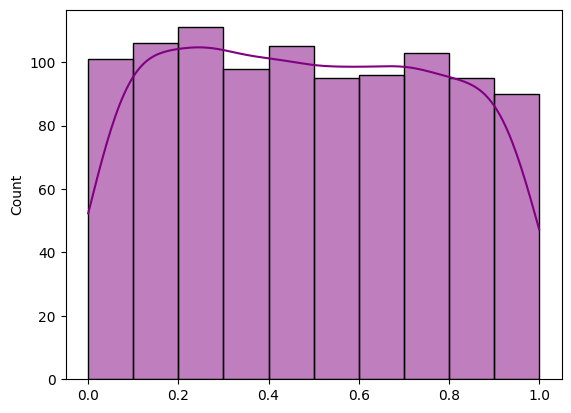

In [ ]:
correctness = []
power = []

for i in tqdm(range(1000)):

    new_df = groups_splitter(shop.copy(), user_salt=salt_generator())
    all_df = pd.merge(new_df, shop_metrics_old[['user_id', 'cart_added_cnt']], on=['user_id'], how='left')
    all_df = all_df.rename(columns={'cart_added_cnt_x': 'cart_added_cnt', 'cart_added_cnt_y': 'cart_added_cnt_covariate'})

    cuped_df = cuped_transform(all_df, ['cart_added_cnt'])
    ranked_df = rank_transformation(cuped_df[cuped_df.group == 'A'], cuped_df[cuped_df.group == 'B'], 'cart_added_cnt_cuped')

    vec_a = ranked_df[(ranked_df['group'] == 'A')]['rank']
    vec_b = ranked_df[(ranked_df['group'] == 'B')]['rank']
    vec_b_effect = cuped_df[cuped_df['group'] == 'B']['cart_added_cnt_cuped'] * 1.05

    cuped_df_b = cuped_df[cuped_df.group == 'B'].drop(columns=['cart_added_cnt_cuped'])
    cuped_df_b['cart_added_cnt_cuped'] = list(vec_b_effect)

    ranked_df_effect = rank_transformation(cuped_df[cuped_df.group == 'A'], cuped_df_b, 'cart_added_cnt_cuped')
    vec_a_power = ranked_df_effect[(ranked_df_effect['group'] == 'A')]['rank']
    vec_b_power = ranked_df_effect[(ranked_df_effect['group'] == 'B')]['rank']

    p_cor, p_power = stats.ttest_ind(vec_a, vec_b).pvalue, stats.ttest_ind(vec_a_power, vec_b_power).pvalue

    correctness.append(p_cor)
    power.append(p_power)

correctness = np.array(correctness)
sns.histplot(data=correctness, bins=10, color='purple', kde=True)

power = np.array(power)
print(f'power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%')

Применение рангового преобразования к данным, уже подвергнутым CUPED-трансформации, не привело к улучшению корректности. Мощность осталась на максимальном уровне в 100%.

### 3. Реализовать разбивку на бакеты, оценить t-критерием и сравнить с результатом без бакетирования


Применим численное бакетирование.

##### **На логнормальном распределении (сгенерированные данные)**

In [ ]:
data_a = np.random.lognormal(mean=0, sigma=1, size=50000)
data_b = np.random.lognormal(mean=0, sigma=1, size=50000)

lognormdata = pd.DataFrame({'value': np.concatenate([data_a, data_b]),
                    'group': ['A'] * len(data_a) + ['B'] * len(data_b)})
lognormdata['bucket'] = pd.qcut(lognormdata['value'], q=1000, labels=False)

group_buckets = lognormdata.groupby(['group', 'bucket'])['value'].mean().reset_index()
group_buckets

,group,bucket,value
0,A,0,0.035680
1,A,1,0.049941
2,A,2,0.058835
3,A,3,0.066847
4,A,4,0.073091
...,...,...,...
1995,B,995,14.066152
1996,B,996,15.315833
1997,B,997,17.181391
1998,B,998,20.060242


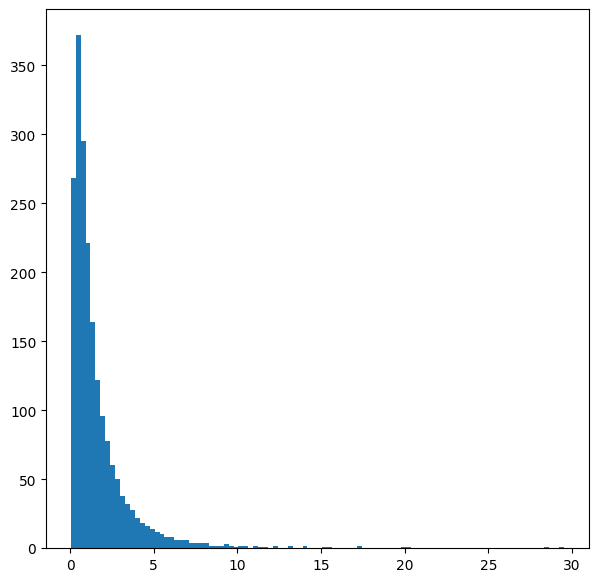

In [ ]:
group_buckets['value'].hist(bins=100, figsize=(7,7))
plt.grid(False)

In [ ]:
print(group_buckets[group_buckets.group == 'A']['value'].mean(),
      group_buckets[group_buckets.group == 'B']['value'].mean(),
      ((group_buckets[group_buckets.group == 'B']['value'].mean() - group_buckets[group_buckets.group == 'A']['value'].mean()) /
       group_buckets[group_buckets.group == 'A']['value'].mean()*100))

1.651082199924173 1.6516608831722863 0.035048724293676226


In [ ]:
stats.ttest_ind(group_buckets[group_buckets.group == 'A']['value'], group_buckets[group_buckets.group == 'B']['value'])

TtestResult(statistic=-0.006034203439613304, pvalue=0.9951860338569065, df=1998.0)

##### **На метрике cart_added_cnt**

In [ ]:
shop_metrics_new['cart_added_cnt_bucket'] = pd.qcut(shop_metrics_new['cart_added_cnt'].rank(method='first'), 50000)
group_buckets = shop_metrics_new.groupby(['group', 'cart_added_cnt_bucket'], observed=True)['cart_added_cnt'].mean().reset_index()
group_buckets

,group,cart_added_cnt_bucket,cart_added_cnt
0,A,"(0.999, 5.45]",0.000000
1,A,"(5.45, 9.901]",0.000000
2,A,"(9.901, 14.351]",0.000000
3,A,"(14.351, 18.802]",0.000000
4,A,"(18.802, 23.252]",0.000000
...,...,...,...
95092,B,"(222498.748, 222503.198]",19.333333
95093,B,"(222503.198, 222507.649]",22.000000
95094,B,"(222507.649, 222512.099]",24.000000
95095,B,"(222512.099, 222516.55]",33.000000


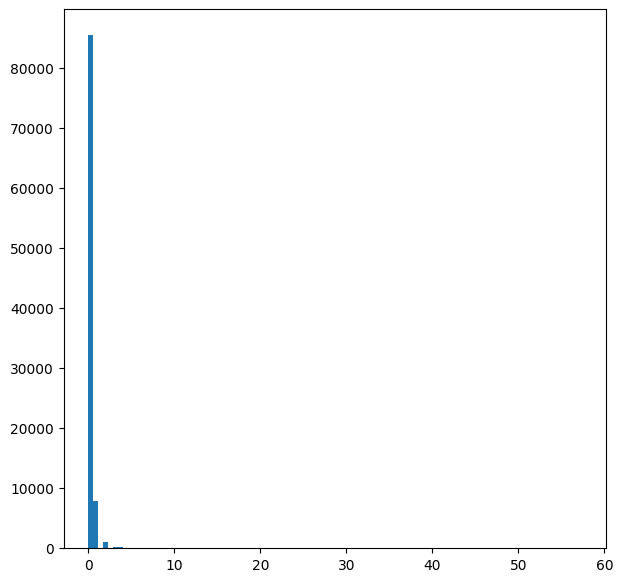

In [ ]:
group_buckets['cart_added_cnt'].hist(bins=100, figsize=(7,7))
plt.grid(False)

In [ ]:
print(group_buckets[group_buckets.group == 'A']['cart_added_cnt'].mean(),
      group_buckets[group_buckets.group == 'B']['cart_added_cnt'].mean(),
      ((group_buckets[group_buckets.group == 'B']['cart_added_cnt'].mean() - group_buckets[group_buckets.group == 'A']['cart_added_cnt'].mean()) /
       group_buckets[group_buckets.group == 'A']['cart_added_cnt'].mean()*100))

0.13677553365138745 0.13726428992339423 0.3573418863438864


In [ ]:
stats.ttest_ind(group_buckets[group_buckets.group == 'A']['cart_added_cnt'], group_buckets[group_buckets.group == 'B']['cart_added_cnt'])

TtestResult(statistic=-0.11895715216672388, pvalue=0.9053095535533993, df=95095.0)

  0%|          | 0/1000 [00:00<?, ?it/s]

power: 8.0% , correctness: 100.0%


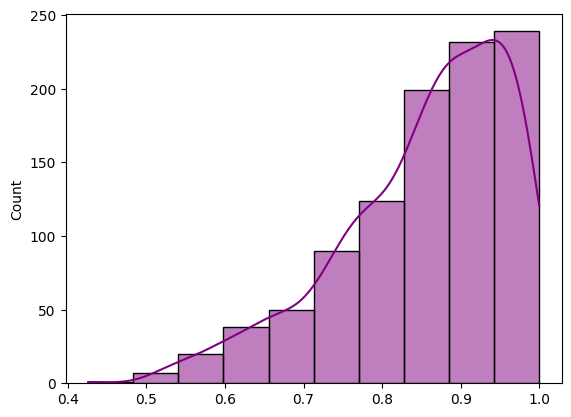

In [ ]:
correctness = []
power = []

for i in tqdm(range(1000)):
    new_df = groups_splitter(shop.copy(), user_salt=salt_generator())

    new_df['cart_added_cnt_bucket'] = pd.qcut(new_df['cart_added_cnt'].rank(method='first'), 50000)
    bucket_df = new_df.groupby(['group', 'cart_added_cnt_bucket'], observed=True)['cart_added_cnt'].mean().reset_index()

    vec_a = bucket_df[(bucket_df['group'] == 'A')]['cart_added_cnt']
    vec_b = bucket_df[(bucket_df['group'] == 'B')]['cart_added_cnt']

    vec_b_effect = new_df[new_df['group'] == 'B']['cart_added_cnt'] * 1.05
    new_df_b = new_df[new_df.group == 'B'].drop(columns=['cart_added_cnt'])
    new_df_b['cart_added_cnt'] = list(vec_b_effect)
    new_df_b_bucket = new_df_b.groupby(['cart_added_cnt_bucket'], observed=True)['cart_added_cnt'].mean().reset_index()

    p_cor, p_power = stats.ttest_ind(vec_a, vec_b).pvalue, stats.ttest_ind(vec_a, new_df_b_bucket['cart_added_cnt']).pvalue

    correctness.append(p_cor)
    power.append(p_power)

correctness = np.array(correctness)
sns.histplot(data=correctness, bins=10, color='purple', kde=True)

power = np.array(power)
print(f'power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%')

Бакетирование довольно простой метод, но для лучших результатов, лучше стоит понимать природу данных и их распределения, чтобы выбрать наиболее подходящий метод

### 4. Реализовать постстратификацию на данных shop_metrics_old для метрики cart_added_cnt

In [ ]:
print(shop_metrics_old[shop_metrics_old.group == 'A']['cart_added_cnt'].mean(),
      shop_metrics_old[shop_metrics_old.group == 'B']['cart_added_cnt'].mean(),
      ((shop_metrics_old[shop_metrics_old.group == 'B']['cart_added_cnt'].mean() - shop_metrics_old[shop_metrics_old.group == 'A']['cart_added_cnt'].mean()) /
       shop_metrics_old[shop_metrics_old.group == 'A']['cart_added_cnt'].mean()*100))

0.1202000629499941 0.12155144034943767 1.1242734540045785


In [ ]:
stats.ttest_ind(shop_metrics_old[shop_metrics_old.group == 'A']['cart_added_cnt'],
                shop_metrics_old[shop_metrics_old.group == 'B']['cart_added_cnt'])

TtestResult(statistic=-0.7331870372707812, pvalue=0.4634447828246868, df=406861.0)

In [ ]:
shop_w_features = pd.merge(shop_metrics_old, shop_users_info, on=['user_id'], how='left')

In [ ]:
shop_w_features['age_group'] = pd.cut(
    shop_w_features['user_age'],
    bins=[17, 24, 45, 60, 75, 999],
    labels=['18-24', '25-45', '46-60', '61-75', '76+'],
    right=True
)

In [ ]:
shop_w_features['age_sex_group'] = shop_w_features['age_group'].astype(str) + '_' + shop_w_features['user_sex']

In [ ]:
shop_w_features.drop(['age_group'], axis=1, inplace=True)
shop_w_features.head()

,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt,user_age,user_sex,age_sex_group
0,1515915625353226922,B,1,1,76.48,0.0,0.0,0,0,55,f,46-60_f
1,1515915625353230067,A,1,1,28.98,0.0,0.0,0,0,58,m,46-60_m
2,1515915625353230683,A,1,10,592.21,0.0,0.0,0,0,23,f,18-24_f
3,1515915625353230922,A,1,1,274.40,0.0,0.0,0,0,33,m,25-45_m
4,1515915625353234047,A,1,14,1857.94,0.0,0.0,0,0,26,f,25-45_f


In [ ]:
shop_w_features.groupby('group')['age_sex_group'].value_counts()

group  age_sex_group
A      25-45_m          38432
       46-60_m          27321
       61-75_m          27001
       25-45_f          25540
       46-60_f          18336
       61-75_f          17939
       76+_m            16249
       18-24_m          12890
       76+_f            11125
       18-24_f           8503
B      25-45_m          38490
       46-60_m          27283
       61-75_m          27249
       25-45_f          25439
       61-75_f          18246
       46-60_f          18111
       76+_m            16362
       18-24_m          12816
       76+_f            11082
       18-24_f           8449
Name: count, dtype: int64

In [ ]:
N = shop_w_features['user_id'].nunique()

strats_weights = {}
for i in range(0, shop_w_features['age_sex_group'].nunique()):
    key = shop_w_features['age_sex_group'].value_counts().index[i]
    strats_weights[key] = shop_w_features['age_sex_group'].value_counts().iloc[i] / N

strats_weights

{'25-45_m': 0.18906118275684936,
 '46-60_m': 0.1342073376050415,
 '61-75_m': 0.13333726586099007,
 '25-45_f': 0.12529770463276335,
 '46-60_f': 0.08958052219051622,
 '61-75_f': 0.08893657078672673,
 '76+_m': 0.08015228713350686,
 '18-24_m': 0.06318097246493291,
 '76+_f': 0.05458102604562224,
 '18-24_f': 0.04166513052305076}

In [ ]:
def stratification_t_test(df_a, df_b, strats_weights, N):
    mean_a = df_a[(df_a['age_sex_group'] == '18-24_m')]['cart_added_cnt'].mean() * strats_weights['18-24_m']\
        + df_a[(df_a['age_sex_group'] == '25-45_m')]['cart_added_cnt'].mean() * strats_weights['25-45_m']\
        + df_a[(df_a['age_sex_group'] == '46-60_m')]['cart_added_cnt'].mean() * strats_weights['46-60_m']\
        + df_a[(df_a['age_sex_group'] == '61-75_m')]['cart_added_cnt'].mean() * strats_weights['61-75_m']\
        + df_a[(df_a['age_sex_group'] == '76+_m')]['cart_added_cnt'].mean() * strats_weights['76+_m']\
        + df_a[(df_a['age_sex_group'] == '18-24_f')]['cart_added_cnt'].mean() * strats_weights['18-24_f']\
        + df_a[(df_a['age_sex_group'] == '25-45_f')]['cart_added_cnt'].mean() * strats_weights['25-45_f']\
        + df_a[(df_a['age_sex_group'] == '46-60_f')]['cart_added_cnt'].mean() * strats_weights['46-60_f']\
        + df_a[(df_a['age_sex_group'] == '61-75_f')]['cart_added_cnt'].mean() * strats_weights['61-75_f']\
        + df_a[(df_a['age_sex_group'] == '76+_f')]['cart_added_cnt'].mean() * strats_weights['76+_f']

    mean_b = df_b[(df_b['age_sex_group'] == '18-24_m')]['cart_added_cnt'].mean() * strats_weights['18-24_m']\
        + df_b[(df_b['age_sex_group'] == '25-45_m')]['cart_added_cnt'].mean() * strats_weights['25-45_m']\
        + df_b[(df_b['age_sex_group'] == '46-60_m')]['cart_added_cnt'].mean() * strats_weights['46-60_m']\
        + df_b[(df_b['age_sex_group'] == '61-75_m')]['cart_added_cnt'].mean() * strats_weights['61-75_m']\
        + df_b[(df_b['age_sex_group'] == '76+_m')]['cart_added_cnt'].mean() * strats_weights['76+_m']\
        + df_b[(df_b['age_sex_group'] == '18-24_f')]['cart_added_cnt'].mean() * strats_weights['18-24_f']\
        + df_b[(df_b['age_sex_group'] == '25-45_f')]['cart_added_cnt'].mean() * strats_weights['25-45_f']\
        + df_b[(df_b['age_sex_group'] == '46-60_f')]['cart_added_cnt'].mean() * strats_weights['46-60_f']\
        + df_b[(df_b['age_sex_group'] == '61-75_f')]['cart_added_cnt'].mean() * strats_weights['61-75_f']\
        + df_b[(df_b['age_sex_group'] == '76+_f')]['cart_added_cnt'].mean() * strats_weights['76+_f']

    std_a = (df_a[(df_a['age_sex_group'] == '18-24_m')]['cart_added_cnt'].std()**2 * strats_weights['18-24_m']\
        + df_a[(df_a['age_sex_group'] == '25-45_m')]['cart_added_cnt'].std()**2 * strats_weights['25-45_m']\
        + df_a[(df_a['age_sex_group'] == '46-60_m')]['cart_added_cnt'].std()**2 * strats_weights['46-60_m']\
        + df_a[(df_a['age_sex_group'] == '61-75_m')]['cart_added_cnt'].std()**2 * strats_weights['61-75_m']\
        + df_a[(df_a['age_sex_group'] == '76+_m')]['cart_added_cnt'].std()**2 * strats_weights['76+_m']\
        + df_a[(df_a['age_sex_group'] == '18-24_f')]['cart_added_cnt'].std()**2 * strats_weights['18-24_f']\
        + df_a[(df_a['age_sex_group'] == '25-45_f')]['cart_added_cnt'].std()**2 * strats_weights['25-45_f']\
        + df_a[(df_a['age_sex_group'] == '46-60_f')]['cart_added_cnt'].std()**2 * strats_weights['46-60_f']\
        + df_a[(df_a['age_sex_group'] == '61-75_f')]['cart_added_cnt'].std()**2 * strats_weights['61-75_f']\
        + df_a[(df_a['age_sex_group'] == '76+_f')]['cart_added_cnt'].std()**2 * strats_weights['76+_f'])

    std_a /= N

    std_b = (df_b[(df_b['age_sex_group'] == '18-24_m')]['cart_added_cnt'].std()**2 * strats_weights['18-24_m']\
        + df_b[(df_b['age_sex_group'] == '25-45_m')]['cart_added_cnt'].std()**2 * strats_weights['25-45_m']\
        + df_b[(df_b['age_sex_group'] == '46-60_m')]['cart_added_cnt'].std()**2 * strats_weights['46-60_m']\
        + df_b[(df_b['age_sex_group'] == '61-75_m')]['cart_added_cnt'].std()**2 * strats_weights['61-75_m']\
        + df_b[(df_b['age_sex_group'] == '76+_m')]['cart_added_cnt'].std()**2 * strats_weights['76+_m']\
        + df_b[(df_b['age_sex_group'] == '18-24_f')]['cart_added_cnt'].std()**2 * strats_weights['18-24_f']\
        + df_b[(df_b['age_sex_group'] == '25-45_f')]['cart_added_cnt'].std()**2 * strats_weights['25-45_f']\
        + df_b[(df_b['age_sex_group'] == '46-60_f')]['cart_added_cnt'].std()**2 * strats_weights['46-60_f']\
        + df_b[(df_b['age_sex_group'] == '61-75_f')]['cart_added_cnt'].std()**2 * strats_weights['61-75_f']\
        + df_b[(df_b['age_sex_group'] == '76+_f')]['cart_added_cnt'].std()**2 * strats_weights['76+_f'])

    std_b /= N

    return {
        "effect": (mean_b - mean_a)/mean_a*100,
        "std_a": std_a,
        "std_b": std_b,
        "pvalue": stats.ttest_ind_from_stats(mean_a, std_a, len(df_a), mean_b, std_b, len(df_b)).pvalue,
    }

In [ ]:
stratification_t_test(df_a=shop_w_features[shop_w_features.group == 'A'], df_b=shop_w_features[shop_w_features.group == 'B'],strats_weights=strats_weights, N=N)

{'effect': 1.123890989435155,
 'std_a': 8.179175411680734e-07,
 'std_b': 8.814427810323407e-07,
 'pvalue': 0.0}

  0%|          | 0/1000 [00:00<?, ?it/s]

power: 100.0% , correctness: 0.0%


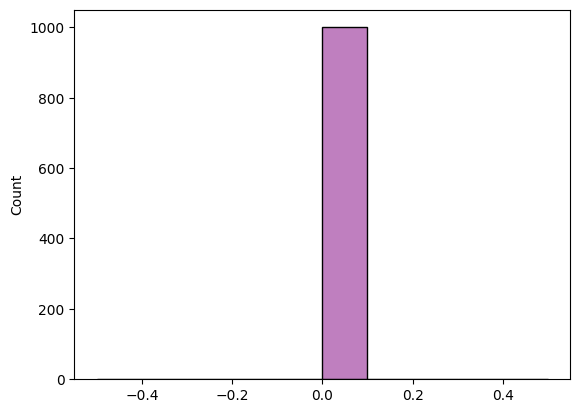

In [ ]:
correctness = []
power = []

for i in tqdm(range(1000)):

    new_df = groups_splitter(shop_w_features.copy(), user_salt=salt_generator())

    vec_b_effect = new_df[new_df['group'] == 'B']['cart_added_cnt'] * 1.05
    new_df_b = new_df[new_df.group == 'B'].drop(columns=['cart_added_cnt'])
    new_df_b['cart_added_cnt'] = list(vec_b_effect)

    p_cor = stratification_t_test(df_a=new_df[new_df.group == 'A'],
                                  df_b=new_df[new_df.group == 'B'],
                                  N=N, strats_weights=strats_weights)["pvalue"]
    p_power = stratification_t_test(df_a=new_df[new_df.group == 'A'],
                                  df_b=new_df_b, N=N,
                                  strats_weights=strats_weights)["pvalue"]

    correctness.append(p_cor)
    power.append(p_power)

correctness = np.array(correctness)
sns.histplot(data=correctness, bins=10, color='purple', kde=True)

power = np.array(power)
print(f'power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%')

Постстратификация позволила учесть различия в группах с сочетанием пола и возраста и повысить точность оценки эффекта. Это может улучшить интерпретацию результатов A/B теста, обеспечив более корректное сравнение групп.

### Общие выводы

Рассмотрены различные подходы для повышения чувствительности тестов, включая:

1. Ранговую трансформацию;
2. CUPED-трансформацию;
3. Бакетирование;
4. Постстратификацию.

Комбинация подходов не всегда даёт лучшие результаты. Важно экспериментировать с подходами, понимать природу данных и т.д.